In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from IPython.display import HTML
from stable_baselines3.common.env_checker import check_env

HTML("<style>div.output_area pre { font-family: 'Courier New', monospace; }</style>")

In [3]:
from apad_env import APADEnv, has_islands

In [4]:
# N.B. check_env doesn't mask, so we merely print an error and truncate the game.
env = APADEnv()
assert check_env(env, warn=True) is None

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


Coordinate system: Top left is 0,0. Zeroeth row, second column would be 0,2.

# Basic sanity checks

In [6]:
def test_environment():
    env = APADEnv()

    # Test 1: Grid initialization
    assert env.grid.shape == (7, 7)
    assert np.sum(env.grid == -1) in {6, 7, 8}  # Invalid positions
    assert np.sum(env.remaining_pieces) == 8  # All pieces available

    # Test 2: Piece coordinate generation
    coords_k = env._get_piece_coords(0, 0, 0)  # K piece, no flip, no rotation
    expected_k = [(0, 0), (1, 0), (2, 0), (3, 0), (2, 1)]
    assert coords_k == expected_k

    # Test 3: Rotation
    coords_k_rot = env._get_piece_coords(0, 0, 1)  # K piece rotated 90°
    assert len(coords_k_rot) == 5

    # Test 4: Valid placement
    valid = env._is_valid_placement(0, 0, 0, 14)  # Position (2,0) on grid
    assert isinstance(valid, (bool, np.bool_))

    # Test 5: Invalid placement (out of bounds)
    valid = env._is_valid_placement(0, 0, 0, 6)  # Top-right corner invalid
    assert valid is False

    # Test 6: Piece placement
    if env._is_valid_placement(0, 0, 0, 14):
        env._place_piece_components(0, 0, 0, 14)
        assert not env.remaining_pieces[0]  # Piece marked as used
        assert np.sum(env.grid == 1) == 5  # 5 cells occupied by piece

    print("All tests passed")


test_environment()

All tests passed


### Make sure we can't place pieces on top of each other. Make sure we can reset the environment.

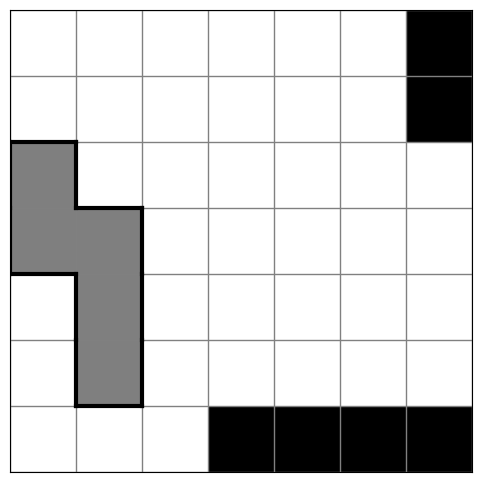

Overlap and reset tests passed!


In [7]:
def test_overlap_and_reset():
    env = APADEnv(-1, -1)

    # Find two valid positions for same piece type
    pos1 = 14  # Should be valid
    pos2 = 15  # Adjacent position

    # Place first piece
    if env._is_valid_placement(0, 0, 0, pos1):
        env._place_piece_components(1, 0, 0, pos1)
        env.visualize()

        # Try to place overlapping piece (should fail)
        overlap_valid = env._is_valid_placement(0, 0, 0, pos2)
        assert overlap_valid is False

        # Test reset
        obs, info = env.reset()
        assert np.sum(env.remaining_pieces) == 8  # All pieces available
        assert np.sum(env.grid > 0) == 0  # Only invalid cells marked

    print("Overlap and reset tests passed!")
    return env


test_overlap_and_reset()

# Date selection validation

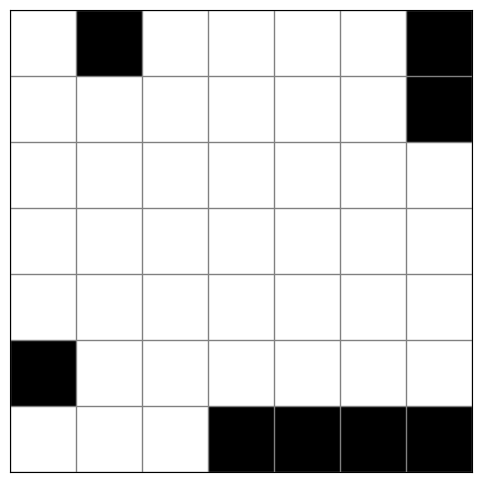

In [8]:
env = APADEnv(2, 22)  # feb 22
env.visualize()

# Validate island-finding

In [9]:
from scipy.ndimage import label


def validate_island_finding(grid):
    # pass label() a grid of T/F, T where the cells are 0 (empty), F where they are !=0 (invalid/occupied).
    labeled_array, num_features = label(env.grid == 0)

    # 1's where there are empty cells, 0's where they are occupied/invalid
    print("here's the grid as the island finder sees it")
    print(labeled_array)

    # number of separate groups.
    print(f"there are {num_features} separate islands of unoccupied cells")

    # flatten the grid to 1D
    # print(labeled_array.ravel())

    # [number of 0s, number of not-zeroes in group1, number of not-zeroes in group2, ...]
    print(
        "\nthe numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)"
    )
    print(np.bincount(labeled_array.ravel()))

    island_sizes = np.bincount(labeled_array.ravel())[1:]

    # Check if any islands have 4 or fewer cells
    print("\nAre there groups of unoccupied cells of size <= 4?")
    print(np.any(island_sizes <= 4))

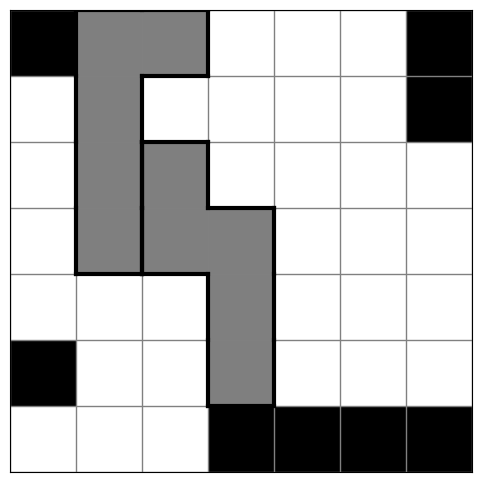

here's the grid as the island finder sees it
[[0 0 0 1 1 1 0]
 [2 0 1 1 1 1 0]
 [2 0 0 1 1 1 1]
 [2 0 0 0 1 1 1]
 [2 2 2 0 1 1 1]
 [0 2 2 0 1 1 1]
 [2 2 2 0 0 0 0]]
there are 2 separate islands of unoccupied cells

the numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)
[18 20 11]

Are there groups of unoccupied cells of size <= 4?
False


In [10]:
env = APADEnv(1, 22)
env._place_piece_components(6, 0, 0, 1)
env._place_piece_components(1, 0, 0, 16)
# env._place_piece_components(2, 0, 0, 4)
env.visualize()
validate_island_finding(env.grid)
assert not has_islands(env.grid)

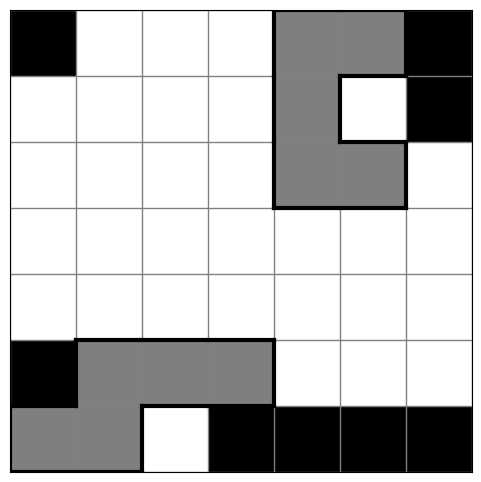

here's the grid as the island finder sees it
[[0 1 1 1 0 0 0]
 [1 1 1 1 0 2 0]
 [1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 3 0 0 0 0]]
there are 3 separate islands of unoccupied cells

the numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)
[18 29  1  1]

Are there groups of unoccupied cells of size <= 4?
True


In [11]:
# we'll allow single islands because in the case where we don't restric solutions, 2 empty singles is the win con
env = APADEnv(1, 22)
env._place_piece_components(1, 0, 1, 35)
env._place_piece_components(2, 0, 0, 4)
env.visualize()
validate_island_finding(env.grid)
assert has_islands(env.grid)

# Piece placement visualization and sanity-checks
Make sure pieces are being placed correctly. And understand the action->position/piece/rotation/chirality encoding.
e.g. 
- action 2408 = Z piece placed in the top-left
- action 2451 = Z piece placed int he top-left, but rotated
- 2451 - 2408 = 43 possible cells where each piece can be placed
- in practice, not all of these cells are valid, even if the board is empty

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


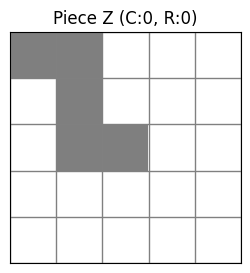

In [12]:
env = APADEnv()
action = 2408
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 1, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


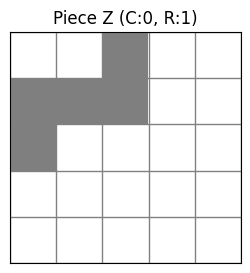

In [13]:
action = 2451
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

At action 2580 (=2451+3*43, for the 3 remaining rotation configurations in each possible cell), we get our first chirality flip for the z-piece

Chosen action: {'piece_id': 7, 'chirality': 1, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


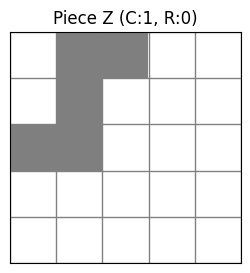

In [14]:
action = 2580
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

# Action Masking validation

In [15]:
env = APADEnv()
assert env.action_masks().shape == (env.action_space.n,)

# of valid actions 773


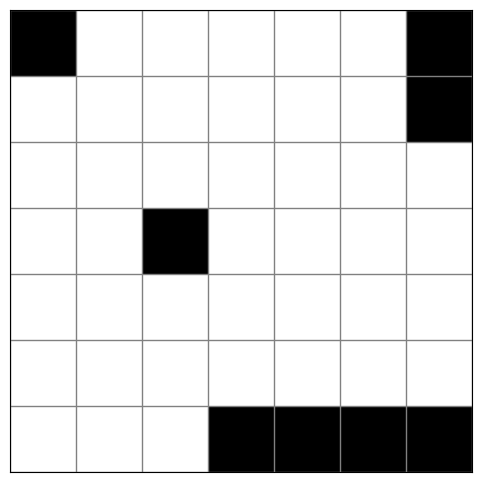

In [16]:
env = APADEnv(1, 10)
mask = env.action_masks()
print(f"# of valid actions {np.flatnonzero(mask).size}")
env.visualize()

# Run through a single random game

In [17]:
def test_random_trial(mon=None, day=None):
    env = APADEnv(mon, day)
    # env = APADEnv()
    obs, _ = env.reset()
    done = truncated = False

    while not (done or truncated):
        # Ask the environment which actions are legal right now
        mask = env.action_masks()  # boolean array
        valid_actions = np.flatnonzero(mask)  # integer indices of True values

        if valid_actions.size == 0:
            # No possible moves ⇒ truncate / end the episode
            truncated = True
            break

        action = np.random.choice(valid_actions)
        obs, reward, done, truncated, info = env.step(action)

    return env, done, truncated, action

Win? False. Lose? True. Has islands? True


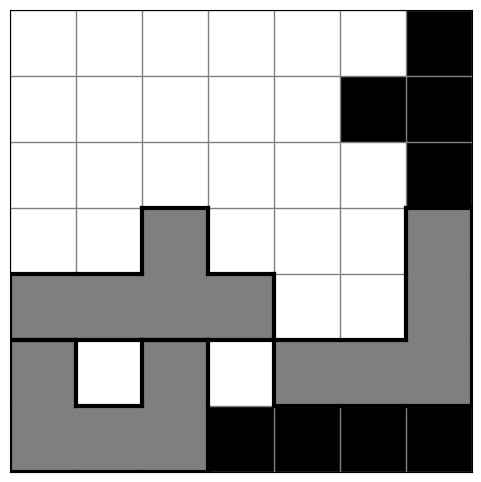

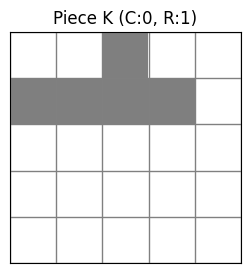

In [18]:
env, done, truncated, terminal_action = test_random_trial()
print(f"Win? {done}. Lose? {truncated}. Has islands? {has_islands(env.grid)}")
env.visualize()
env.visualize_piece(terminal_action)

# Play random trials
now that we require specific date solutions, we don't get random wins very often. I think the rate is ~1/50k.
Repeatedly do: create a random board, make random moves until we win or lose. No second attempts or backtracking or learning.

trial 3208 15.0 seconds elapsed... 213.85 games/second, wins: 0
trial 6410 30.0 seconds elapsed... 213.65 games/second, wins: 0
trial 9636 45.0 seconds elapsed... 214.12 games/second, wins: 0
trial 12816 60.0 seconds elapsed... 213.57 games/second, wins: 0
trial 15923 75.0 seconds elapsed... 212.27 games/second, wins: 0
trial 19104 90.0 seconds elapsed... 212.23 games/second, wins: 0
trial 22250 105.0 seconds elapsed... 211.87 games/second, wins: 0
trial 25421 120.0 seconds elapsed... 211.81 games/second, wins: 0
trial 28638 135.0 seconds elapsed... 212.10 games/second, wins: 0
trial 31858 150.0 seconds elapsed... 212.36 games/second, wins: 0
trial 35007 165.0 seconds elapsed... 212.13 games/second, wins: 0
trial 38212 180.0 seconds elapsed... 212.25 games/second, wins: 0
trial 41430 195.0 seconds elapsed... 212.43 games/second, wins: 0
trial 44620 210.0 seconds elapsed... 212.44 games/second, wins: 0
trial 47802 225.0 seconds elapsed... 212.42 games/second, wins: 0
trial 51025 240.0 s

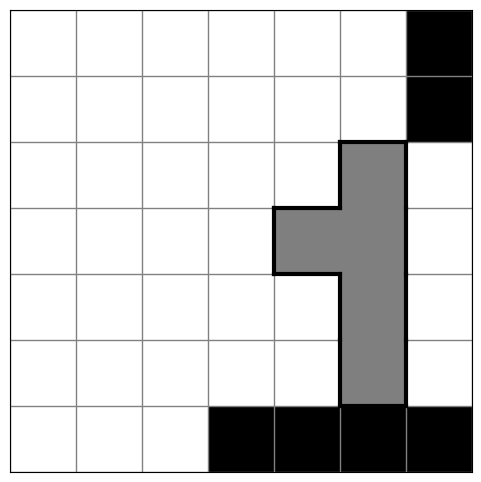

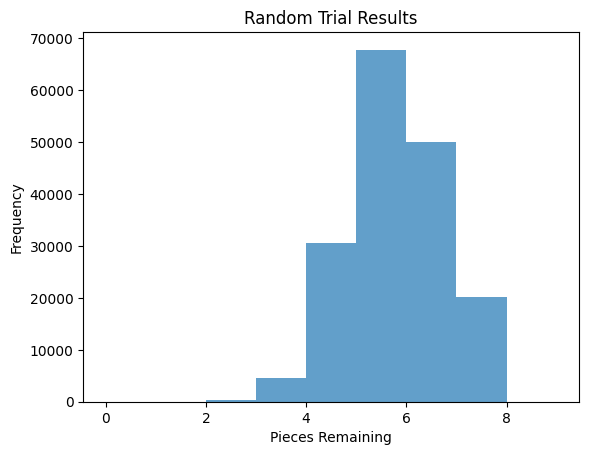

Trials: 173741, Success rate: 0.00%, wins: 0
0


In [19]:
import time

start_time = time.time()
last_print = start_time

i = 0
remaining_pieces = []
win = 0
try:
    while True:
        i += 1
        env, done, truncated, terminal_action = test_random_trial(-1, -1)
        remaining_pieces.append(sum(env.remaining_pieces))
        if done:  # win
            env.visualize()
            win += 1
        current_time = time.time()
        if current_time - last_print >= 15:
            elapsed = current_time - start_time
            print(
                f"trial {i} {elapsed:.1f} seconds elapsed... {i/elapsed:.2f} games/second, wins: {win}"
            )
            last_print = current_time

except KeyboardInterrupt:
    env.visualize()

plt.hist(remaining_pieces, bins=range(10), alpha=0.7)
plt.xlabel("Pieces Remaining")
plt.ylabel("Frequency")
plt.title("Random Trial Results")
plt.savefig("imgs/trial_results.png")
plt.show()

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}, wins: {win}")
print(win)

~~most of the time we end up with 2 remaining pieces when we place them all randomly~~

~~bricking the game in the step function when islands of 2-4 empty cells remain reduces the number of trials required by 10-20x.~~

- bricking the game on (islands of 3,4,9,14), (an island of 2 any number of islands of 1), or (more than 2 islands of 1) brings us up to 0.2% success

Now we're requiring a solution to a specific date: win rate is somewhere < 0.01%, not surprising

We used to be at 15 games/sec. But now we're at 200 games/sec from the numpy and caching strategies. Much better.

In [ ]:
has_islands(env.grid)